# <a>Introduction</a>  

**Hands and palm images dataset from Kaggle** : https://www.kaggle.com/datasets/shyambhu/hands-and-palm-images-dataset?fbclid=IwY2xjawGOChhleHRuA2FlbQIxMAABHc2HBhzsvWUc4vP-7fUUk2ZHoNznPlh-OrE2Ax4Jc7vLLDj6pTcKD2T6zQ_aem_5SamZx8D7TuJwg16miEdWA

* 11k Hands Dataset: collection of 11.076 images (1600 X 1200 pixels) from 190 subjects
* Both Hands: Each subject open and closed fingers of both left and right hands
* Two Sides: Photos include both dorsal and palmar sides, with a white background and consistent camera distance 

# <a>Import</a>  

In [21]:
import numpy as np
from matplotlib import pyplot as plt 
from itertools import product
import cv2
import sys
import os
import re
from PIL import Image 
import PIL

# <a>Preprocess</a>  

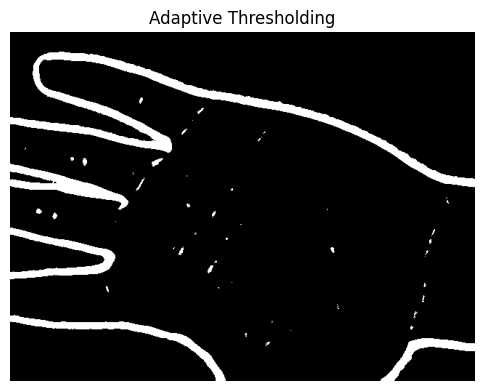

Adaptive thresholding image saved at: Test\adaptive_threshold_3.jpg


In [22]:
output_folder = 'Test'
img_name = '3.jpg'

os.makedirs(output_folder, exist_ok=True)

img = cv2.imread(img_name)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian smoothing
gaussian_blur = cv2.GaussianBlur(gray_image, (11, 11), 0)

# Apply adaptive thresholding with updated parameters
adaptive_thresh = cv2.adaptiveThreshold(
    gaussian_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 6
)

# Save the adaptive thresholding result in the "Test" folder
adaptive_thresh_path = os.path.join(output_folder, f'adaptive_threshold_{img_name}')
cv2.imwrite(adaptive_thresh_path, adaptive_thresh)

# Display the results 
plt.figure(figsize=(6, 6))
plt.title("Adaptive Thresholding")
plt.imshow(adaptive_thresh, cmap='gray')
plt.axis('off')
plt.show()

print(f"Adaptive thresholding image saved at: {adaptive_thresh_path}")


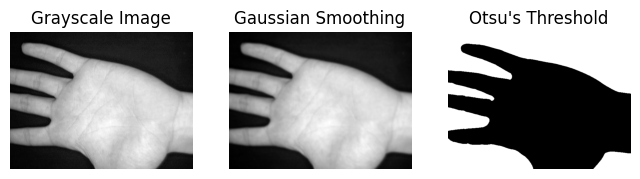

Binary image saved at: Test\hand_binary_otsu.jpg


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

img_name = '3.jpg' 
image = cv2.imread(img_name)
if image is None:
    raise ValueError("Image not found. Please check the path and filename.")

# Step 1: Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Apply Gaussian smoothing to reduce noise
gaussian_blur = cv2.GaussianBlur(gray_image, (11, 11), 0)

# Step 3: Apply Otsu's thresholding to create a binary mask
_, binary_image = cv2.threshold(gaussian_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Display the result
plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.title("Grayscale Image")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Gaussian Smoothing")
plt.imshow(gaussian_blur, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Otsu's Threshold")
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

plt.show()

# Save the final binary image
output_folder = 'Test'
os.makedirs(output_folder, exist_ok=True)
binary_image_path = os.path.join(output_folder, 'hand_binary_otsu.jpg')
cv2.imwrite(binary_image_path, binary_image)
print(f"Binary image saved at: {binary_image_path}")


In [18]:
class PROIE():
    def __init__(self):
        pass

    def _threshold(self):
        self.blur_img = cv2.GaussianBlur(self.in_img_g, (5, 5), 0)
        # apply for black background image
        _, self.thresh_img = cv2.threshold(self.blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    def _contours(self):
        self.contours, _ = cv2.findContours(self.thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        self.contours = self.contours[0]
        self.contour_img = self.in_img_c.copy()
        self.contour_img = cv2.drawContours(self.contour_img, [self.contours], 0, (255, 0, 0), 2)

    def _landmarks(self):
        M = cv2.moments(self.thresh_img)
        x_c = M['m10'] // M['m00']
        y_c = M['m01'] // M['m00']
        self.center_point = {"x": x_c, "y": y_c}
        self.contours = self.contours.reshape(-1, 2)
        left_id = np.argmin(self.contours.sum(-1))
        self.contours = np.concatenate(
            [self.contours[left_id:, :], self.contours[:left_id, :]])
        dist_c = np.sqrt(np.square(
            self.contours-[self.center_point["x"], self.center_point["y"]]).sum(-1))
        f = np.fft.rfft(dist_c)
        cutoff = 15
        f_new = np.concatenate([f[:cutoff], 0*f[cutoff:]])
        dist_c_1 = np.fft.irfft(f_new)
        derivative = np.diff(dist_c_1)
        sign_change = np.diff(np.sign(derivative))/2
        self.landmarks = {"x": [], "y": []}
        for landmark in self.contours[np.where(sign_change > 0)[0]]:
            self.landmarks["x"].append(landmark[0])
            self.landmarks["y"].append(landmark[1])

    def _landmarks_select(self):
        y_rank = np.array(np.argsort(self.landmarks["y"]))
        self.landmarks_selected = {"x": np.array(self.landmarks["x"])[
            y_rank][:3], "y": np.array(self.landmarks["y"])[y_rank][:3]}

        x_rank = np.array(np.argsort(self.landmarks_selected["x"]))
        self.landmarks_selected = {
            "x": self.landmarks_selected["x"][x_rank][[0, 2]], "y": self.landmarks_selected["y"][x_rank][[0, 2]]}

    def _alignement(self):
        h, w = self.in_img_g.shape
        theta = np.arctan2((self.landmarks_selected["y"][1] - self.landmarks_selected["y"][0]), (
            self.landmarks_selected["x"][1] - self.landmarks_selected["x"][0]))*180/np.pi
        R = cv2.getRotationMatrix2D(
            (int(self.landmarks_selected["x"][1]), int(self.landmarks_selected["y"][1])), theta, 1)
        self.align_img = cv2.warpAffine(self.in_img_g, R, (w, h))

        point_1 = [self.landmarks_selected["x"]
                   [0], self.landmarks_selected["y"][0]]
        point_2 = [self.landmarks_selected["x"]
                   [1], self.landmarks_selected["y"][1]]

        point_1 = (R[:, :2] @ point_1 + R[:, -1]).astype(int)
        point_2 = (R[:, :2] @ point_2 + R[:, -1]).astype(int)

        self.landmarks_selected_align = {
            "x": [point_1[0], point_2[0]], "y": [point_1[1], point_2[1]]}

    def _roi_extract(self, margin = 0):
        point_1 = np.array([self.landmarks_selected_align["x"]
                            [0], self.landmarks_selected_align["y"][0]])
        point_2 = np.array([self.landmarks_selected_align["x"]
                            [1], self.landmarks_selected_align["y"][1]])

        self.ux = max(0, point_1[0] - margin) 
        self.uy = max(0, point_1[1] + (point_2 - point_1)[0] // 3 - margin)
        self.lx = min(self.align_img.shape[1], point_2[0] + margin) 
        self.ly = min(self.align_img.shape[0], point_2[1] + 4 * (point_2 - point_1)[0] // 3 + margin)


        self.roi_zone_img = cv2.cvtColor(self.align_img, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(self.roi_zone_img, (self.lx, self.ly),(self.ux, self.uy), (0, 255, 0), 2)

        self.roi_img = self.align_img[self.uy:self.ly, self.ux:self.lx]


    def extract_roi(self, path_in_img, rotate=False):
        self.in_img_c = cv2.imread(path_in_img)
        if(rotate):
            self.in_img_c = cv2.rotate(self.in_img_c, cv2.ROTATE_90_CLOCKWISE)

        if len(self.in_img_c.shape) == 3:
            self.in_img_g = cv2.cvtColor(self.in_img_c, cv2.COLOR_BGR2GRAY)
        else:
            self.in_img_g = self.in_img_c

        self._threshold()
        self._contours()
        self._landmarks()
        self._landmarks_select()
        self._alignement()
        self._roi_extract()

    def save(self, path_out_img):
        cv2.imwrite(path_out_img, self.roi_img)

    def show_result(self):
        plt.figure()

        plt.subplot(241)
        plt.imshow(self.in_img_g, cmap="gray")
        plt.title("original")

        plt.subplot(242)
        plt.imshow(self.thresh_img, cmap="gray")
        plt.title("threshold")

        plt.subplot(243)
        plt.imshow(self.contour_img, cmap="gray")
        plt.plot(self.center_point["x"], self.center_point["y"], 'bx')
        plt.title("contours")

        plt.subplot(244)
        plt.imshow(self.in_img_c, cmap="gray")
        for idx in range(len(self.landmarks["x"])):
            plt.plot(self.landmarks["x"][idx], self.landmarks["y"][idx], 'rx')
        plt.title("landmarks")

        plt.subplot(245)
        plt.imshow(self.in_img_c, cmap="gray")
        plt.plot(self.landmarks_selected["x"][0],
                 self.landmarks_selected["y"][0], 'rx')
        plt.plot(self.landmarks_selected["x"][1],
                 self.landmarks_selected["y"][1], 'rx')
        plt.title("selected")

        plt.subplot(246)
        plt.imshow(self.align_img, cmap="gray")
        plt.plot(self.landmarks_selected_align["x"][0],
                 self.landmarks_selected_align["y"][0], 'rx')
        plt.plot(self.landmarks_selected_align["x"][1],
                 self.landmarks_selected_align["y"][1], 'rx')
        plt.title("alignement")

        plt.subplot(247)
        plt.imshow(self.roi_zone_img, cmap="gray")
        plt.title("roi zone")

        plt.subplot(248)
        plt.imshow(self.roi_img, cmap="gray")
        plt.title("extraction")

        plt.show()

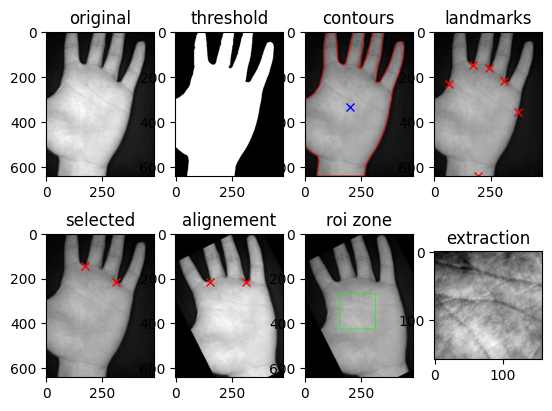

In [ ]:
path_in_img = "4.jpg"
proie = PROIE()

proie.extract_roi(path_in_img, rotate=True)
proie.show_result()
proie.save('test')